# Modeling Hot Water Energy

### Attach current folder to project directory
### Ensure Seed for reproducability
### Set GPU configurations

In [1]:
seed_value = 123

import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Select the period at which we perform experiments

In [3]:
period = 6  # the period to sample the data at. 1 period= 5 minutes

### Read the cleaned data

In [4]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


In [5]:
# Smoothing the data
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

df_smoothed = dp.dfsmoothing(df=df,
                             column_names=list(df.columns),
                             order=order,
                             Wn=cutoff,
                             T=T)

Finished 'dataframeplot' in 0.0403 secs


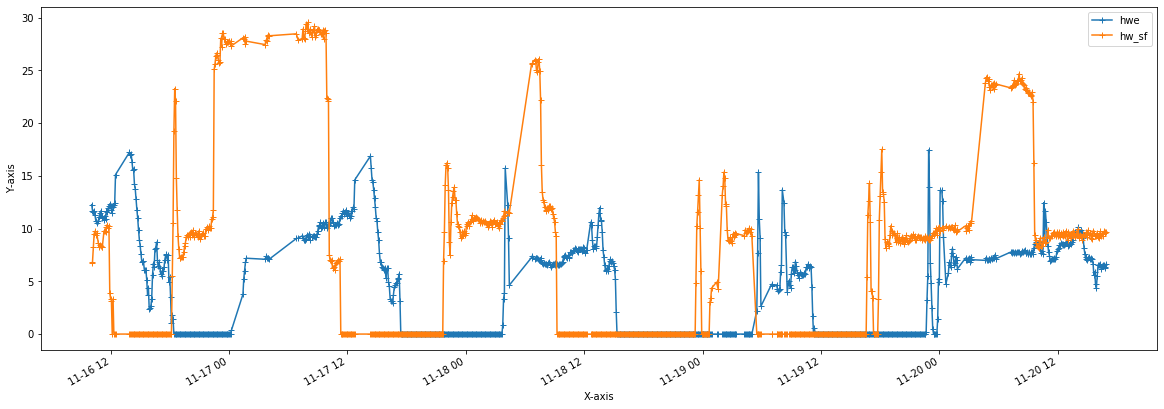

In [5]:
#%matplotlib notebook
dp.dataframeplot(df=df.loc[df.index[:1000], ['hwe','hw_sf']],
                lazy=True,
                legend=True,
                style='+-')

### Get time lagged cross correlation information

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

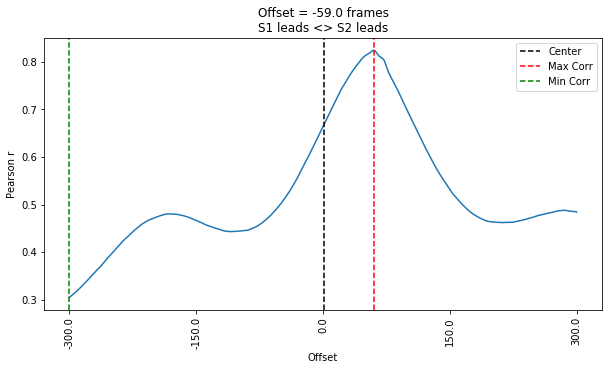

In [15]:
d1 = df['hwe']
d2 = df['hw_sf']
lags =300
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(lags*fps),int(lags*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((lags+1)*fps), lags/2))
ax.set_xticklabels(np.arange(-int(lags*fps),int((lags+1)*fps),lags/2), rotation=90);
plt.legend()

# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

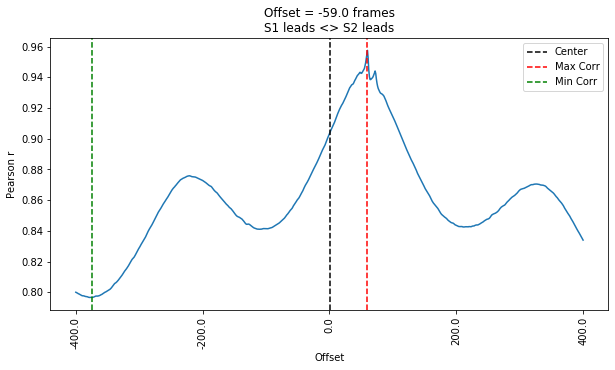

In [17]:
d1 = df['cwe']
d2 = df['flow']
lags = 400
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(lags*fps),int(lags*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((lags+1)*fps), lags/2))
ax.set_xticklabels(np.arange(-int(lags*fps),int((lags+1)*fps),lags/2), rotation=90);
plt.legend()

### Since this implies that Hot water flow leads the Hot Water Energy by approximately 59 frames or approximately 5 hours. We will use the flow as an indicator of the hybrid mode changes in the energy prediction problem. 

### Next steps:
1. Shift the hot water energy upwards/move back in time by 58 units.
2. Shift the energy by one more unit for the final prediction. 
3. For training: We break the data into batches separated by 0 energy determined by hot water flow
4. For testing:

    a. Either we do online testing where we utilize the current flow information to decide to predict or not.
    
    b. Again create batches of data based on the flow information and predict only in those batches.

In [6]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


In [7]:
df_out = dp.createlag(df_smoothed, ['hwe','cwe'], lag=-59)

Finished 'dataframeplot' in 0.0643 secs


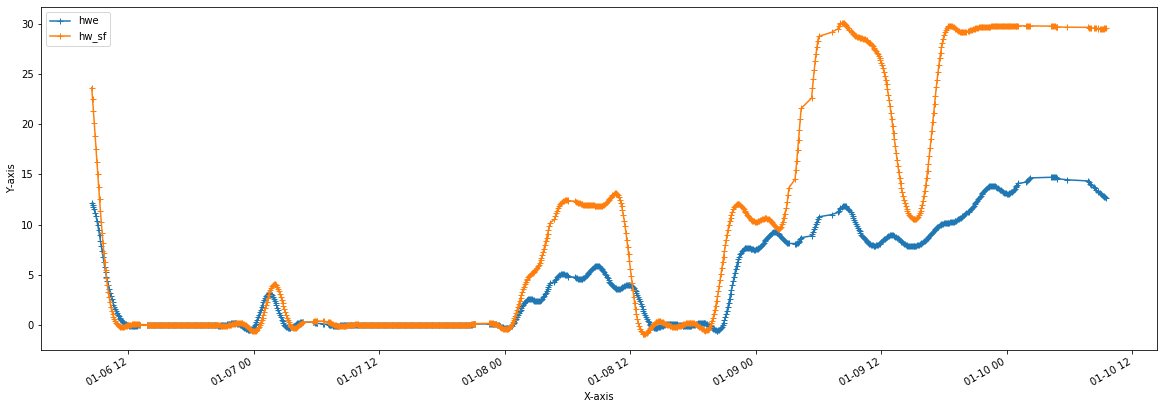

In [8]:
#%matplotlib notebook
dp.dataframeplot(df=df_out.loc[df.index[12000:13000], ['hwe','hw_sf']],
                lazy=True,
                legend=True,
                style='+-')

### Sum half hour energy data

In [9]:
# return a new column which is the sum of previous window_size values
def windowsum(df, window_size: int, column_name: str):
    return df[[column_name]].rolling(window=window_size, min_periods=window_size).sum()

df_out['30min_hwe'] = windowsum(df_out,window_size=period, column_name='hwe')
df_out = dp.dropNaNrows(df_out)

df_out.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.035067,72.294783,86.121997,6.559873,-0.074854,565.999638,72.424800,-0.017122,8.773625,110.377847,96.047695,36.699631
2018-11-16 10:35:00,30.997731,72.083142,86.377001,6.669277,-0.078943,574.117299,72.424054,-0.029541,8.972761,110.919134,95.557149,37.750890
2018-11-16 10:45:00,30.961157,71.883877,86.634097,6.735677,-0.079441,581.797099,72.423763,-0.042205,9.120232,111.389786,95.068595,38.656120
2018-11-16 10:50:00,30.927595,71.699686,86.893274,6.754286,-0.076845,588.914345,72.423979,-0.054667,9.210683,111.780608,94.585195,39.370229
2018-11-16 10:55:00,30.899542,71.533133,87.154282,6.721706,-0.071726,595.343365,72.424745,-0.066429,9.239720,112.084331,94.110440,39.854369


### Sample data at half hour

In [10]:
# Sample the data at half hour intervals
df_out = dp.sample_timeseries_df(df_out, period=period)
df_out.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.035067,72.294783,86.121997,6.559873,-0.074854,565.999638,72.424800,-0.017122,8.773625,110.377847,96.047695,36.699631
2018-11-16 11:00:00,30.879700,71.386590,87.416587,6.635984,-0.064696,600.959785,72.426089,-0.076961,9.204061,112.295743,93.648113,40.076803
2018-11-16 11:30:00,31.005835,71.017611,88.703866,5.441332,-0.021788,612.900220,72.441218,-0.092335,8.031554,111.933015,91.667953,36.713355
2018-11-16 12:00:00,32.003000,71.443384,89.856486,2.929877,-0.004449,582.079452,72.468720,0.017583,4.925408,109.018922,90.525998,24.126601
2018-11-16 12:30:00,34.156805,72.480124,89.755636,0.620724,-0.018241,503.409577,72.479587,0.216607,1.579319,105.337845,91.040496,9.067507


### remove 0 values from the energy

In [133]:
df_out.describe()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
count,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000
mean,61.346177,69.493643,56.865931,3.524106,21.032328,169.852961,71.648641,33.987889,9.413017,102.936938,92.664013,21.142169
std,16.989838,5.652470,16.462856,3.846118,17.346112,255.934165,0.948048,30.335225,9.715231,14.281361,13.907987,23.052392
min,17.562966,51.414037,17.318977,-1.316666,-3.092499,-56.201757,66.101703,-1.806047,-2.484255,80.075722,63.824775,-8.381700
25%,47.244420,67.198887,44.320312,0.043751,5.348388,-0.021009,70.942869,7.624756,0.165661,90.383204,82.271268,0.270462
50%,60.984331,71.731659,56.500982,2.332870,14.966873,10.736843,71.323809,21.405845,6.451078,97.986945,89.975170,13.952004
75%,75.257789,73.137724,69.271714,5.408236,37.663093,266.325098,72.774546,61.839263,13.373266,114.836441,100.332040,32.330008
max,97.158479,78.917628,93.536813,17.007696,77.450150,963.483816,73.561111,125.401192,32.706693,150.216620,136.016809,101.827837


In [11]:
df_out = df_out[df_out['30min_hwe']>1]

### Create 7 day chunks of data

In [12]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df_out[['oat', 'orh', 'sat', 'ghi', 'hw_sf', '30min_hwe', 'hw_st']],
                      subsequence=True,
                      period=period,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 60


### Custom way to create Training Data; Choose inputs, outputs, lags, train-test splits etc

In [71]:
data_weeks = 52 # Create a large initial block 6 months ~ 26 weeks of training and testing data
splitvalue =  (data_weeks-1)/data_weeks  # One week for training
weeklist = []  # create list of training, testing arrays
inputcols = ['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st']  # input data
outputcols = ['30min_hwe']  # output data
lag = -1  # predict next time step energy

from pandas import concat
def quickmerge(listdf):
    return concat(listdf)

### Initial Data Block for offline training

In [72]:
datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)

X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue,
    input_timesteps=1,
    )
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler
    })

### Create small blocks of data for weekly training

In [73]:
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=0.66,
        input_timesteps=1,
    )
    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 9


### Print size and shape of data to feed to the LSTM for sanity checks

In [74]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler'):
            print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, value: Year-2018-Week-46
name: X_train, value: (10830, 1, 6)
name: y_train, value: (10830, 1, 1)
name: X_test, value: (213, 1, 6)
name: y_test, value: (213, 1, 1)
name: Id, value: Year-2019-Week-51
name: X_train, value: (7185, 1, 6)
name: y_train, value: (7185, 1, 1)
name: X_test, value: (3702, 1, 6)
name: y_test, value: (3702, 1, 1)
name: Id, value: Year-2019-Week-52
name: X_train, value: (7182, 1, 6)
name: y_train, value: (7182, 1, 1)
name: X_test, value: (3700, 1, 6)
name: y_test, value: (3700, 1, 1)
name: Id, value: Year-2020-Week-1
name: X_train, value: (7185, 1, 6)
name: y_train, value: (7185, 1, 1)
name: X_test, value: (3702, 1, 6)
name: y_test, value: (3702, 1, 1)
name: Id, value: Year-2020-Week-2
name: X_train, value: (7168, 1, 6)
name: y_train, value: (7168, 1, 1)
name: X_test, value: (3693, 1, 6)
name: y_test, value: (3693, 1, 1)
name: Id, value: Year-2020-Week-3
name: X_train, value: (7120, 1, 6)
name: y_train, value: (7120, 1, 1)
name: X_test, value: (3669, 1, 6)

### Create Folder to save models and tensorboard logs

In [75]:
path = '../results/lstm_hwe_trial5/'
!rm -rf ../results/lstm_hwe_trial5

# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Clear the Tensorflow graph from previous training

In [27]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Configure the LSTM model architecture

In [76]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':5000,
    'retrain_from_layers':6

}

In [19]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

### Start the week by week training procedure

In [144]:
modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']
    y_scaler = weekdata['y_scaler']

    if not modeldesigndone:
        
        try:
            del nn_model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        nn_model = mp.seq2seq_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                            input_timesteps=X_train.shape[-2],
                              period=period,
                                hybird_modes=10)

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
                           densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        nn_model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train, y_train, X_test, y_test, epochs=modelconfig['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Idx=weekdata['Id'],
                                                     outputdim_names=['Hot Water Energy'])
    
    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False
            
    if reinitialize:  
        for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())
    
    # compile model
    nn_model.model_compile()


  0%|          | 0/9 [00:00<?, ?it/s]

Train on 10830 samples, validate on 213 samples
Epoch 1/5000
 - 7s - loss: 0.0422 - val_loss: 0.1722
Epoch 2/5000
 - 4s - loss: 0.0282 - val_loss: 0.1790
Epoch 3/5000
 - 4s - loss: 0.0283 - val_loss: 0.1796
Epoch 4/5000
 - 4s - loss: 0.0493 - val_loss: 0.1623
Epoch 5/5000
 - 4s - loss: 0.0465 - val_loss: 0.1581
Epoch 6/5000
 - 4s - loss: 0.0450 - val_loss: 0.1560
Epoch 7/5000
 - 4s - loss: 0.0433 - val_loss: 0.1534
Epoch 8/5000
 - 4s - loss: 0.0412 - val_loss: 0.1503
Epoch 9/5000
 - 4s - loss: 0.0389 - val_loss: 0.1460
Epoch 10/5000
 - 4s - loss: 0.0363 - val_loss: 0.1397
Epoch 11/5000
 - 4s - loss: 0.0334 - val_loss: 0.1313
Epoch 12/5000
 - 4s - loss: 0.0302 - val_loss: 0.1204
Epoch 13/5000
 - 4s - loss: 0.0268 - val_loss: 0.1075
Epoch 14/5000
 - 4s - loss: 0.0232 - val_loss: 0.0928
Epoch 15/5000
 - 4s - loss: 0.0195 - val_loss: 0.0771
Epoch 16/5000
 - 4s - loss: 0.0161 - val_loss: 0.0619
Epoch 17/5000
 - 4s - loss: 0.0134 - val_loss: 0.0500
Epoch 18/5000
 - 4s - loss: 0.0116 - val_lo


 11%|█         | 1/9 [04:41<37:32, 281.53s/it]

Train on 227 samples, validate on 118 samples
Epoch 66/5000
 - 1s - loss: 0.3438 - val_loss: 0.2627
Epoch 67/5000
 - 0s - loss: 0.2945 - val_loss: 0.2222
Epoch 68/5000
 - 0s - loss: 0.2485 - val_loss: 0.1843
Epoch 69/5000
 - 0s - loss: 0.2056 - val_loss: 0.1490
Epoch 70/5000
 - 0s - loss: 0.1659 - val_loss: 0.1166
Epoch 71/5000
 - 0s - loss: 0.1300 - val_loss: 0.0880
Epoch 72/5000
 - 0s - loss: 0.0988 - val_loss: 0.0640
Epoch 73/5000
 - 0s - loss: 0.0736 - val_loss: 0.0456
Epoch 74/5000
 - 0s - loss: 0.0552 - val_loss: 0.0333
Epoch 75/5000
 - 0s - loss: 0.0437 - val_loss: 0.0266
Epoch 76/5000
 - 0s - loss: 0.0383 - val_loss: 0.0240
Epoch 77/5000
 - 0s - loss: 0.0366 - val_loss: 0.0235
Epoch 78/5000
 - 0s - loss: 0.0366 - val_loss: 0.0235
Epoch 79/5000
 - 0s - loss: 0.0366 - val_loss: 0.0235
Epoch 80/5000
 - 0s - loss: 0.0365 - val_loss: 0.0235
Epoch 81/5000
 - 0s - loss: 0.0364 - val_loss: 0.0234
Epoch 82/5000
 - 0s - loss: 0.0364 - val_loss: 0.0234
Epoch 83/5000
 - 0s - loss: 0.0364 -


 22%|██▏       | 2/9 [04:47<23:12, 198.92s/it]

Train on 225 samples, validate on 117 samples
Epoch 109/5000
 - 1s - loss: 0.2883 - val_loss: 0.0593
Epoch 110/5000
 - 0s - loss: 0.2567 - val_loss: 0.0504
Epoch 111/5000
 - 0s - loss: 0.2283 - val_loss: 0.0423
Epoch 112/5000
 - 0s - loss: 0.2016 - val_loss: 0.0349
Epoch 113/5000
 - 0s - loss: 0.1761 - val_loss: 0.0281
Epoch 114/5000
 - 0s - loss: 0.1514 - val_loss: 0.0218
Epoch 115/5000
 - 0s - loss: 0.1275 - val_loss: 0.0164
Epoch 116/5000
 - 0s - loss: 0.1046 - val_loss: 0.0119
Epoch 117/5000
 - 0s - loss: 0.0835 - val_loss: 0.0088
Epoch 118/5000
 - 0s - loss: 0.0651 - val_loss: 0.0071
Epoch 119/5000
 - 0s - loss: 0.0500 - val_loss: 0.0071
Epoch 120/5000
 - 0s - loss: 0.0389 - val_loss: 0.0082
Epoch 121/5000
 - 0s - loss: 0.0317 - val_loss: 0.0084
Epoch 122/5000
 - 0s - loss: 0.0311 - val_loss: 0.0085
Epoch 123/5000
 - 0s - loss: 0.0306 - val_loss: 0.0086
Epoch 124/5000
 - 0s - loss: 0.0301 - val_loss: 0.0088
Epoch 125/5000
 - 0s - loss: 0.0297 - val_loss: 0.0088
Epoch 126/5000
 - 0


 33%|███▎      | 3/9 [04:51<14:02, 140.50s/it]

Train on 344 samples, validate on 178 samples
Epoch 128/5000
 - 1s - loss: 0.1779 - val_loss: 0.1940
Epoch 129/5000
 - 0s - loss: 0.1515 - val_loss: 0.1654
Epoch 130/5000
 - 0s - loss: 0.1289 - val_loss: 0.1385
Epoch 131/5000
 - 0s - loss: 0.1076 - val_loss: 0.1128
Epoch 132/5000
 - 0s - loss: 0.0872 - val_loss: 0.0882
Epoch 133/5000
 - 0s - loss: 0.0679 - val_loss: 0.0656
Epoch 134/5000
 - 0s - loss: 0.0504 - val_loss: 0.0462
Epoch 135/5000
 - 0s - loss: 0.0357 - val_loss: 0.0311
Epoch 136/5000
 - 0s - loss: 0.0247 - val_loss: 0.0211
Epoch 137/5000
 - 0s - loss: 0.0175 - val_loss: 0.0158
Epoch 138/5000
 - 0s - loss: 0.0138 - val_loss: 0.0139
Epoch 139/5000
 - 0s - loss: 0.0122 - val_loss: 0.0136
Epoch 140/5000
 - 0s - loss: 0.0117 - val_loss: 0.0138
Epoch 141/5000
 - 0s - loss: 0.0115 - val_loss: 0.0140
Epoch 142/5000
 - 0s - loss: 0.0114 - val_loss: 0.0140
Epoch 143/5000
 - 0s - loss: 0.0113 - val_loss: 0.0140
Epoch 144/5000
 - 0s - loss: 0.0113 - val_loss: 0.0141
Epoch 145/5000
 - 0


 44%|████▍     | 4/9 [04:56<08:19, 99.87s/it] 

Train on 432 samples, validate on 224 samples
Epoch 148/5000
 - 1s - loss: 0.1782 - val_loss: 0.1143
Epoch 149/5000
 - 0s - loss: 0.1376 - val_loss: 0.0804
Epoch 150/5000
 - 0s - loss: 0.0967 - val_loss: 0.0512
Epoch 151/5000
 - 0s - loss: 0.0594 - val_loss: 0.0330
Epoch 152/5000
 - 0s - loss: 0.0318 - val_loss: 0.0306
Epoch 153/5000
 - 0s - loss: 0.0180 - val_loss: 0.0398
Epoch 154/5000
 - 0s - loss: 0.0146 - val_loss: 0.0477
Epoch 155/5000
 - 0s - loss: 0.0143 - val_loss: 0.0478
Epoch 156/5000
 - 0s - loss: 0.0143 - val_loss: 0.0477
Epoch 157/5000
 - 0s - loss: 0.0143 - val_loss: 0.0475
Epoch 158/5000
 - 0s - loss: 0.0143 - val_loss: 0.0473
Epoch 159/5000
 - 0s - loss: 0.0142 - val_loss: 0.0473
Epoch 160/5000
 - 0s - loss: 0.0142 - val_loss: 0.0473



 56%|█████▌    | 5/9 [05:01<04:44, 71.16s/it]

Train on 391 samples, validate on 202 samples
Epoch 161/5000
 - 1s - loss: 0.0532 - val_loss: 0.0728
Epoch 162/5000
 - 0s - loss: 0.0382 - val_loss: 0.0580
Epoch 163/5000
 - 0s - loss: 0.0249 - val_loss: 0.0451
Epoch 164/5000
 - 0s - loss: 0.0146 - val_loss: 0.0359
Epoch 165/5000
 - 0s - loss: 0.0085 - val_loss: 0.0313
Epoch 166/5000
 - 0s - loss: 0.0064 - val_loss: 0.0299
Epoch 167/5000
 - 0s - loss: 0.0061 - val_loss: 0.0297
Epoch 168/5000
 - 0s - loss: 0.0060 - val_loss: 0.0298
Epoch 169/5000
 - 0s - loss: 0.0059 - val_loss: 0.0298
Epoch 170/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298
Epoch 171/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298
Epoch 172/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298
Epoch 173/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298
Epoch 174/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298
Epoch 175/5000
 - 0s - loss: 0.0058 - val_loss: 0.0298



 67%|██████▋   | 6/9 [05:05<02:33, 51.14s/it]

Train on 289 samples, validate on 150 samples
Epoch 176/5000
 - 1s - loss: 0.0399 - val_loss: 0.1684
Epoch 177/5000
 - 0s - loss: 0.0268 - val_loss: 0.1359
Epoch 178/5000
 - 0s - loss: 0.0170 - val_loss: 0.1079
Epoch 179/5000
 - 0s - loss: 0.0112 - val_loss: 0.0873
Epoch 180/5000
 - 0s - loss: 0.0090 - val_loss: 0.0759
Epoch 181/5000
 - 0s - loss: 0.0089 - val_loss: 0.0724
Epoch 182/5000
 - 0s - loss: 0.0090 - val_loss: 0.0733
Epoch 183/5000
 - 0s - loss: 0.0091 - val_loss: 0.0752
Epoch 184/5000
 - 0s - loss: 0.0090 - val_loss: 0.0754
Epoch 185/5000
 - 0s - loss: 0.0090 - val_loss: 0.0755
Epoch 186/5000
 - 0s - loss: 0.0090 - val_loss: 0.0756
Epoch 187/5000
 - 0s - loss: 0.0090 - val_loss: 0.0756
Epoch 188/5000
 - 0s - loss: 0.0090 - val_loss: 0.0756
Epoch 189/5000
 - 0s - loss: 0.0090 - val_loss: 0.0757



 78%|███████▊  | 7/9 [05:09<01:14, 37.01s/it]

Train on 366 samples, validate on 190 samples
Epoch 190/5000
 - 2s - loss: 0.1799 - val_loss: 0.1961
Epoch 191/5000
 - 0s - loss: 0.1387 - val_loss: 0.1494
Epoch 192/5000
 - 0s - loss: 0.1036 - val_loss: 0.1090
Epoch 193/5000
 - 0s - loss: 0.0740 - val_loss: 0.0747
Epoch 194/5000
 - 0s - loss: 0.0505 - val_loss: 0.0481
Epoch 195/5000
 - 0s - loss: 0.0345 - val_loss: 0.0308
Epoch 196/5000
 - 0s - loss: 0.0262 - val_loss: 0.0222
Epoch 197/5000
 - 0s - loss: 0.0234 - val_loss: 0.0192
Epoch 198/5000
 - 0s - loss: 0.0230 - val_loss: 0.0185
Epoch 199/5000
 - 0s - loss: 0.0229 - val_loss: 0.0186
Epoch 200/5000
 - 0s - loss: 0.0227 - val_loss: 0.0189
Epoch 201/5000
 - 0s - loss: 0.0225 - val_loss: 0.0189
Epoch 202/5000
 - 0s - loss: 0.0224 - val_loss: 0.0189
Epoch 203/5000
 - 0s - loss: 0.0224 - val_loss: 0.0190
Epoch 204/5000
 - 0s - loss: 0.0224 - val_loss: 0.0190
Epoch 205/5000
 - 0s - loss: 0.0224 - val_loss: 0.0190
Epoch 206/5000
 - 0s - loss: 0.0224 - val_loss: 0.0190



 89%|████████▉ | 8/9 [05:14<00:27, 27.35s/it]

Train on 386 samples, validate on 200 samples
Epoch 207/5000
 - 2s - loss: 0.2803 - val_loss: 0.3755
Epoch 208/5000
 - 0s - loss: 0.2120 - val_loss: 0.2993
Epoch 209/5000
 - 0s - loss: 0.1522 - val_loss: 0.2284
Epoch 210/5000
 - 0s - loss: 0.0994 - val_loss: 0.1621
Epoch 211/5000
 - 0s - loss: 0.0560 - val_loss: 0.1061
Epoch 212/5000
 - 0s - loss: 0.0277 - val_loss: 0.0675
Epoch 213/5000
 - 0s - loss: 0.0159 - val_loss: 0.0482
Epoch 214/5000
 - 0s - loss: 0.0139 - val_loss: 0.0422
Epoch 215/5000
 - 0s - loss: 0.0140 - val_loss: 0.0422
Epoch 216/5000
 - 0s - loss: 0.0138 - val_loss: 0.0439
Epoch 217/5000
 - 0s - loss: 0.0136 - val_loss: 0.0440
Epoch 218/5000
 - 0s - loss: 0.0136 - val_loss: 0.0441
Epoch 219/5000
 - 0s - loss: 0.0136 - val_loss: 0.0441
Epoch 220/5000
 - 0s - loss: 0.0136 - val_loss: 0.0441
Epoch 221/5000
 - 0s - loss: 0.0136 - val_loss: 0.0441
Epoch 222/5000
 - 0s - loss: 0.0136 - val_loss: 0.0441



100%|██████████| 9/9 [05:19<00:00, 35.51s/it]


### Plot the week by week CVRMSE error

Name of the file:  ../results/lstm_hwe_trial5/30min Results_File.txt


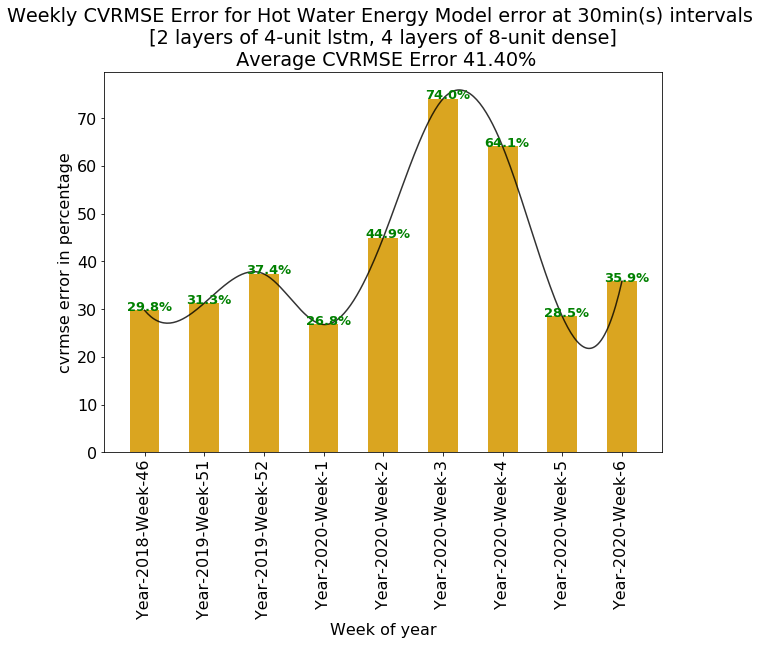

In [145]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Custom method to plot all the relevant variables

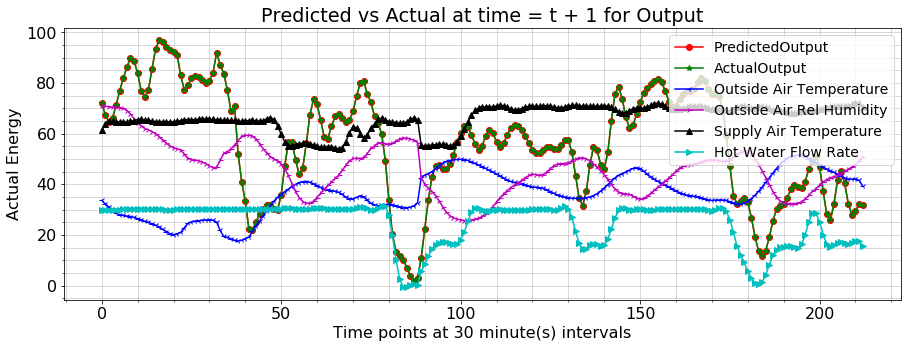

In [79]:
weekdata = modelconfig['weeklist'][0]
X_train = weekdata['X_train']
y_train = weekdata['y_train']
X_test = weekdata['X_test']
y_test = weekdata['y_test']
y_scaler = weekdata['y_scaler']
X_scaler = weekdata['X_scaler']

detailedplot(30, 1, 1, 1, y_test, y_test,X_test, './', True, X_scaler, y_scaler, typeofplot='Custom', Idx=weekdata['Id'])

In [78]:
import matplotlib.pyplot as plt
import numpy as np
# inputcols = ['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'] 
def detailedplot(timegap, outputdim, output_timesteps, input_timesteps, pred, target, X_var,
 saveloc, scaling: bool, Xscaler, yscaler, lag: int = -1, outputdim_names : list = [], typeofplot: str = 'train', 
                 Idx: str = ''):
    
	if not outputdim_names:
		outputdim_names = ['Output']*outputdim
        
	_pred = np.empty_like(pred)
	_target = np.empty_like(target)
	_X_var = np.empty_like(X_var)

	plt.rcParams["figure.figsize"] = (15, 5*outputdim*output_timesteps)
	font = {'size':16}
	plt.rc('font',**font)
	plt.rc('legend',**{'fontsize':14})

	# Inerse scaling the data for each time step
	if scaling:
		for j in  range(output_timesteps):
			_pred[:,j,:] = y_scaler.inverse_transform(pred[:,j,:])
			_target[:,j,:] = yscaler.inverse_transform(target[:,j,:])
		for j in  range(input_timesteps):
			_X_var[:,j,:] = Xscaler.inverse_transform(X_var[:,j,:])     

	# attach forward slash if saveloc does not have one
	if not saveloc.endswith('/'):
			saveloc += '/'


	# training output
	fig, axs = plt.subplots(nrows = outputdim*output_timesteps, squeeze=False)
	for i in range(outputdim):
		for j in range(output_timesteps):
			# plot predicted
			axs[i+j, 0].plot(_pred[:, j, i], 'ro-', label='Predicted'+outputdim_names[i])
			# plot target
			axs[i+j, 0].plot(_target[:, j, i], 'g*-', label='Actual'+outputdim_names[i])
			# plot other variables: temperature
			axs[i+j, 0].plot(_X_var[:, j, 0], 'b3-', label='Outside Air Temperature')
			# plot other variables: relative humidity
			axs[i+j, 0].plot(_X_var[:, j, 1], 'm4-', label='Outside Air Rel Humidity')
			# plot other variables: Supply Air Temperature
			axs[i+j, 0].plot(_X_var[:, j, 2], 'k^-', label='Supply Air Temperature')
			# plot other variables: flow value
			axs[i+j, 0].plot(_X_var[:, j, 4], 'c>-', label='Hot Water Flow Rate')
			# Plot Properties
			axs[i+j, 0].set_title('Predicted vs Actual at time = t + {} for {}'.format(-1*lag+j, outputdim_names[i]))
			axs[i+j, 0].set_xlabel('Time points at {} minute(s) intervals'.format(timegap))
			axs[i+j, 0].set_ylabel('Actual Energy')
			axs[i+j, 0].grid(which='both',alpha=100)
			axs[i+j, 0].legend()
			axs[i+j, 0].minorticks_on()
	#fig.savefig(saveloc+str(timegap)+'min_LSTM_'+typeofplot+'detailedplot-{}.pdf'.format(Idx), bbox_inches='tight')
	#plt.close(fig)
	plt.show(fig)     
    
            
    
    

### Code cemetery

In [30]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)

In [ ]:
# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)

In [ ]:
#model.model.summary()

#nn_model.model.layers[-1].input_shape

#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())

#nn_model.model.layers[-1].output_shape

In [27]:
nn_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 6)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 4)         176         input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 4)            144         lstm_1[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 4)         0           lstm_2[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LS

In [28]:
for layer in nn_model.model.layers:
     print(layer, layer.trainable, layer.name, layer.name.startswith('lstm'))

<keras.engine.input_layer.InputLayer object at 0x7fdf40af6e48> False input_1 False
<keras.layers.recurrent.LSTM object at 0x7fdf40ae6b00> True lstm_1 True
<keras.layers.recurrent.LSTM object at 0x7fdf416416a0> True lstm_2 True
<keras.layers.core.RepeatVector object at 0x7fdf40ae62e8> True repeat_vector_1 False
<keras.layers.recurrent.LSTM object at 0x7fdf40ae6828> True lstm_3 True
<keras.layers.recurrent.LSTM object at 0x7fe0e492b588> True lstm_4 True
<keras.layers.core.Dense object at 0x7fdf473fe518> True dense_3 False
<keras.layers.core.Dense object at 0x7fe0e01eb278> True dense_4 False
<keras.layers.core.Dense object at 0x7fe0db232d30> True dense_5 False
<keras.layers.core.Dense object at 0x7fdf40ae60f0> True dense_1 False
<keras.layers.core.Dense object at 0x7fe0d89e6e10> True dense_6 False
<keras.layers.core.Dense object at 0x7fe0d609b860> True dense_2 False
<keras.layers.core.Dense object at 0x7fe0dda05898> True dense_7 False
<keras.layers.core.Lambda object at 0x7fdf473fe748> Tr

In [33]:
nn_model.model.layers[-2].__dict__

{'input_spec': InputSpec(min_ndim=2, axes={-1: 8}),
 'supports_masking': True,
 'stateful': False,
 '_trainable_weights': [<tf.Variable 'dense_7/kernel:0' shape=(8, 5) dtype=float32_ref>,
  <tf.Variable 'dense_7/bias:0' shape=(5,) dtype=float32_ref>],
 '_non_trainable_weights': [],
 '_losses': [],
 '_updates': [],
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_built': True,
 '_inbound_nodes': [<keras.engine.base_layer.Node at 0x7fe0db20f470>],
 '_outbound_nodes': [<keras.engine.base_layer.Node at 0x7fe0db20f6a0>,
 'name': 'dense_7',
 'trainable': True,
 '_initial_weights': None,
 'units': 5,
 'activation': <function keras.activations.linear(x)>,
 'use_bias': True,
 'kernel_initializer': <keras.initializers.VarianceScaling at 0x7fe0dda05438>,
 'bias_initializer': <keras.initializers.Zeros at 0x7fe0d61cde10>,
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None,
 'kernel': <tf.Variable 'dense_

In [35]:
nn_model.model.layers[-9].cell.__dict__

{'input_spec': None,
 'supports_masking': False,
 'stateful': False,
 '_trainable_weights': [<tf.Variable 'lstm_4/kernel:0' shape=(4, 16) dtype=float32_ref>,
  <tf.Variable 'lstm_4/recurrent_kernel:0' shape=(4, 16) dtype=float32_ref>,
  <tf.Variable 'lstm_4/bias:0' shape=(16,) dtype=float32_ref>],
 '_non_trainable_weights': [],
 '_losses': [],
 '_updates': [],
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_built': True,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 'name': 'lstm_cell_4',
 'trainable': True,
 '_initial_weights': None,
 'units': 4,
 'activation': <function keras.activations.tanh(x)>,
 'recurrent_activation': <function keras.activations.hard_sigmoid(x)>,
 'use_bias': True,
 'kernel_initializer': <keras.initializers.VarianceScaling at 0x7fdf4736a9b0>,
 'recurrent_initializer': <keras.initializers.Orthogonal at 0x7fe0d889e908>,
 'bias_initializer': <keras.initializers.Zeros at 0x7fe0d889edd8>,
 'unit_forget_bias': True,
 'kernel_regularizer': None,
 'recurrent_re